**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system with an attention model.

This is an **individual assignment** and usual rules for plagiarism apply! With this you agree that: "In submitting this work I confirm that it is entirely my own. I acknowledge that I may be invited to online interview if there is any concern in relation to the integrity of my exam." 

**Write comments and documentation.**



**Student Name: Rishi Gupta**
**Student Id: 20231111**

## Section 1- Data Collection and Preprocessing 


---


**Task 1  (5 marks)**

---

There are few datasets to train an NMT system available from the OPUS project (http://opus.nlpl.eu/).

*  Download a language pair (preferably European language) and **extract** the file(s) and upload it to CoLab
*  Create a list of lines by splitting the text file at every occurrence accordingly, i.e. source and target language
*  Print number of sentences
*  Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
*  Split the data into train, development and test set
*  Print 100th sentence in original script for source and target language

In [56]:
#Import Python libraries
import numpy as np
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding, dot, Activation, concatenate, TimeDistributed, Attention
from keras.callbacks import EarlyStopping
import re
import string
from string import punctuation
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
import pandas as pd
from matplotlib import pyplot 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip /content/drive/MyDrive/ANLP/en-fr.txt.zip

Archive:  /content/drive/MyDrive/ANLP/en-fr.txt.zip
  inflating: Wikipedia.en-fr.en      
  inflating: Wikipedia.en-fr.fr      
  inflating: Wikipedia.en-fr.ids     
  inflating: README                  


In [79]:
#Dataset link
#https://drive.google.com/file/d/1nZsqDuS-EdEjTDLgvOOaDG5Dcj5xnIx7/view?usp=sharing

In [57]:
# Load the dataset
#Source Language - English
#Target Language - French

src_filename="Wikipedia.en-fr.en"
with open(src_filename , 'r') as src_file:
  src_lines=src_file.read().split('\n')

tgt_filename="Wikipedia.en-fr.fr"
with open(tgt_filename , 'r') as tgt_file:
  tgt_lines=tgt_file.read().split('\n')

#Store the source and target sentences in pandas dataframe and filter out the sentences whihc are greater than 9 in length
df = pd.DataFrame(data={'src':src_lines,'tgt':tgt_lines})
df['src_len'] = df['src'].apply(lambda x: len(x.split()))
df['tgt_len'] = df['tgt'].apply(lambda x: len(x.split()))
df = df[(df['src_len'] < 10) & (df['tgt_len'] < 10)]
src_lines = df['src'].tolist()
tgt_lines = df['tgt'].tolist()

In [58]:
# Print Number of sentences
if len(tgt_lines) == len(src_lines):
  print("Number of sentences in source and target language are: {}".format(str(len(src_lines))))

#Limit number of lines to 10000
num_samples = 10000
source_lines = src_lines[: min(num_samples, len(src_lines) - 1)]
target_lines = tgt_lines[: min(num_samples, len(tgt_lines) - 1)]

#Split the data into train, development and test set
split_1 = int(0.9 * len(source_lines)) # (90% train+val(10%) and 10% test)

#Source language
source_train = source_lines[:split_1]
source_val = source_train[:900]
source_test = source_lines[split_1:]

#Target language
target_train = target_lines[:split_1]
target_val = target_lines[:900]
target_test = target_lines[split_1:]

#Print 100th sentence in original script for source and target language
print(source_lines[99])
print(target_lines[99])

Number of sentences in source and target language are: 104647
"Herinneringen uit Japan.
"Herinneringen uit Japan.


**Task 2 (5 marks)** 

---

* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the pre-processing step of the text.
* Print the last 5 sentences of the preprocessed text.
* Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language
  * Source Vocabulary
  * Target Vocabulary





In [59]:
#set for unique qords  in both source and target language
source_words = set()
target_words = set()

#Data Pre-processing
def data_preprocess(sentence):
  sentence = sentence.replace("\u202f"," ").lower() # Replace no-break space with space and convert to lower case
  
  # Delete the punctuation and the numbers
  for p in string.punctuation + "«»" + "0123456789":
      sentence = sentence.replace(p,"")
      
  sentence = re.sub('\s+',' ', sentence)
  sentence = sentence.replace('-','').replace('–','').strip()
          
  return sentence
source_train_lines = [data_preprocess(text) for text in source_lines if text!='']
target_train_lines = [data_preprocess(text) for text in target_lines if text!='']

a = []
b = []
# If both sentences from source and target language are not empty rhen only use otherwise discard it.
for text in zip(source_train_lines,target_train_lines):
  if text[0] !='' and text[1] !='':
    a.append(text[0])
    b.append(text[1])
source_train_lines = a
target_train_lines = b


#Add '<bof>' to denote beginning of sentence and '<eos>' to denote the end of the sentence to each target line
target_train_lines = ['<bof> ' + target_text + ' <eos>' for target_text in target_train_lines]

#Last 5 sentewnces after preprocessing
print(source_train_lines[-5:])
print(target_train_lines[-5:])

#Tokenization or getting set of unique words for source and target
for line in source_train_lines:
  src_wrd_lst = line.split()
  for word in src_wrd_lst:
    if word not in source_words:
      source_words.add(word)
for line in target_train_lines:
  tgt_wrd_lst = line.split()
  for word in tgt_wrd_lst:
    if word not in target_words:
      target_words.add(word)

source_words = sorted(list(source_words)) # Unique workds or tokens in source language
target_words = sorted(list(target_words)) # Unique workds or tokens in target language
num_encoder_tokens = len(source_words)    # Number of Unique workds or tokens in source language
num_decoder_tokens = len(target_words)    # Number of Unique workds or tokens in target language
max_encoder_seq_length = max([len(txt.split()) for txt in source_train_lines]) # Length of sentence with maximum words in source language
max_decoder_seq_length = max([len(txt.split()) for txt in target_train_lines]) # Length of sentence with maximum words in target language

print('Number of samples:', len(source_train_lines))
print('Number of unique source tokens:', num_encoder_tokens)
print('Number of unique target tokens:', num_decoder_tokens)
print('Max sequence length for source language:', max_encoder_seq_length)
print('Max sequence length for target language:', max_decoder_seq_length)
print("Source Vocabulary:",source_words)
print("Target Vocabulary:",target_words)


['silver queen', 'it is also unable to take dye', 'in germany the tree is commonly planted in gardens', 'benedicite dominum', 'tristia obsedit me']
['<bof> silver queen <eos>', '<bof> on est également incapable de la teindre <eos>', '<bof> en allemagne on le plante souvent dans les jardins <eos>', '<bof> benedicite dominum <eos>', '<bof> tristia obsedit me <eos>']
Number of samples: 9178
Number of unique source tokens: 13172
Number of unique target tokens: 14347
Max sequence length for source language: 9
Max sequence length for target language: 11
Source Vocabulary: ['a', 'aaf', 'aap', 'aarhus', 'aaron', 'ab', 'abacus', 'abandon', 'abandoned', 'abandons', 'abaraybone', 'abbas', 'abbaye', 'abbayesii', 'abbe', 'abbey', 'abbott', 'abbreviated', 'abc', 'abcclio', 'abdi', 'abdomen', 'abe', 'abebe', 'abega', 'abenteuer', 'abercrombie', 'abidjan', 'abilities', 'abingdonuk', 'ablainsaintnazaire', 'ablex', 'abner', 'aboard', 'abona', 'aboriginal', 'about', 'above', 'abraham', 'abruptum', 'absen

In [60]:
#Now spltting the source and target language data after pre-processing to avoid applying all the about things separately to train test ansd val set.
X_train, X_test, y_train, y_test = train_test_split(source_train_lines,target_train_lines,test_size = 0.1)

**Task 3 (15 marks)** 

---

---

*  Assign each unique word an integer value (5 marks).
*  Create word embedding for your vocabulary using pre-trained embeddings, for example GloVe or fastText (10 marks) (https://nlp.stanford.edu/projects/glove/ , https://fasttext.cc/docs/en/english-vectors.html)
* Print the first line of the embeddings (see below) 

In [61]:
#Mapping each token with an integer value or index and storing them in dictionary
source_token_index = dict([(word,i) for i, word in enumerate(source_words)])
target_token_index= dict([(word,i) for i, word in enumerate(target_words)])

#Function to create the encoder input, decoder input and target data
def encode_decode(X_data,y_data):
  encoder_input_data=np.zeros((len(X_data),max_encoder_seq_length),dtype='float32')
  decoder_input_data=np.zeros((len(X_data), max_decoder_seq_length),dtype='float32')
  decoder_target_data=np.zeros((len(X_data), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

  for i, (source_train_line,target_train_line) in enumerate(zip(X_data,y_data)):
    for t, word in enumerate(source_train_line.split()):
      encoder_input_data[i,t]=source_token_index[word]

      
    for t, word in enumerate(target_train_line.split()):
      decoder_input_data[i,t]=target_token_index[word]
      if t>0:
        decoder_target_data[i,t-1,target_token_index[word]]=1
  return encoder_input_data, decoder_input_data, decoder_target_data

#Create the encoderr and decoder data fortrain and test
encoder_input_data, decoder_input_data, decoder_target_data = encode_decode(X_train,y_train)
encoder_input_test_data, decoder_input_test_data, decoder_target_test_data = encode_decode(X_test,y_test)

#Word Embedding
# load the glove embedding
embeddings_index = dict()
f = open('/content/drive/MyDrive/ANLP/glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

num_words_inp = min(15000, len(source_token_index) + 1)
num_words_otp = min(15000, len(target_token_index) + 1)

##Create embedding matrix and s troing embedded vector for each word 
embedding_matrix = np.zeros((num_words_inp, 100))
for word, index in source_token_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

Loaded 400000 word vectors.


In [62]:
print(embedding_matrix[0])

[-0.27085999  0.044006   -0.02026    -0.17395     0.6444      0.71213001
  0.35510001  0.47138    -0.29637     0.54426998 -0.72294003 -0.0047612
  0.040611    0.043236    0.29729     0.10725     0.40156001 -0.53662002
  0.033382    0.067396    0.64556003 -0.085523    0.14103     0.094539
  0.74947    -0.19400001 -0.68739003 -0.41740999 -0.22807001  0.12
 -0.48999     0.80944997  0.045138   -0.11898     0.20161     0.39276001
 -0.20121001  0.31354001  0.75304002  0.25907001 -0.11566    -0.029319
  0.93498999 -0.36067     0.52420002  0.23706     0.52714998  0.22869
 -0.51958001 -0.79348999 -0.20367999 -0.50186998  0.18748     0.94282001
 -0.44834    -3.67919993  0.044183   -0.26751     2.19970012  0.241
 -0.033425    0.69553    -0.64472002 -0.0072277   0.89574999  0.20015
  0.46493     0.61932999 -0.1066      0.08691    -0.4623      0.18262
 -0.15849     0.020791    0.19373     0.063426   -0.31672999 -0.48177001
 -1.38479996  0.13669001  0.96859002  0.049965   -0.27379999 -0.035686
 -1.0

## Section 2 Translation Model training



---



**Task 4 (15 marks)**
* Provide code for the encoder using Keras LSTM (5 marks)
* Provide code for the decoder using Keras LSTM (5 marks)
* Train the sequence2sequence (encoder-decoder) model (5 marks) 


In [63]:
#set some parameters for model training
batch_size=64
epochs= 100
latent_dim =256 # latent dimensionality of the encoding space
embedding_shape = 100

In [35]:
#Encoder
encoder_input = Input(shape = (max_encoder_seq_length,), name = 'Encoder_input')
embedded_encoder = Embedding(num_words_inp, embedding_shape, weights=[embedding_matrix])(encoder_input)
encoder_output, state_h, state_c = LSTM(latent_dim, return_state=True)(embedded_encoder)
encoder_state = [state_h,state_c]

In [36]:
# Decoder
decoder_input    = Input(shape = (max_decoder_seq_length,), name = 'Decoder_input')
embedded_decoder = Embedding(num_decoder_tokens, latent_dim)(decoder_input)
decoder_lstm=LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(embedded_decoder, initial_state = encoder_state)
# Using Softmax activation
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name = 'Decoder_Dense')
decoder_output = decoder_dense(decoder_output)


In [37]:
#Model compilation
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer=RMSprop(learning_rate=0.002),loss='categorical_crossentropy', metrics=['accuracy']) #optimizer as RMSprop with learning rate of 002
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 9)]          0                                            
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 9, 100)       1317300     Encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 11, 256)      3672832     Decoder_input[0][0]              
____________________________________________________________________________________________

In [38]:
#model training
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1,
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])
#Save model
model.save('seq2seq_source_target.h5')

Epoch 1/100
117/117 [==============================] - 27s 193ms/step - loss: 4.0122 - accuracy: 0.0903 - val_loss: 3.7862 - val_accuracy: 0.1136
Epoch 2/100
117/117 [==============================] - 22s 186ms/step - loss: 3.3541 - accuracy: 0.1151 - val_loss: 3.6355 - val_accuracy: 0.1175
Epoch 3/100
117/117 [==============================] - 22s 188ms/step - loss: 3.0119 - accuracy: 0.1287 - val_loss: 3.5494 - val_accuracy: 0.1334
Epoch 4/100
117/117 [==============================] - 22s 187ms/step - loss: 2.7670 - accuracy: 0.1395 - val_loss: 3.5695 - val_accuracy: 0.1392
Epoch 5/100
117/117 [==============================] - 22s 188ms/step - loss: 2.5320 - accuracy: 0.1510 - val_loss: 3.6205 - val_accuracy: 0.1464
Epoch 6/100
117/117 [==============================] - 22s 189ms/step - loss: 2.3460 - accuracy: 0.1617 - val_loss: 3.6498 - val_accuracy: 0.1514
Epoch 7/100
117/117 [==============================] - 22s 192ms/step - loss: 2.1482 - accuracy: 0.1730 - val_loss: 3.7396 -

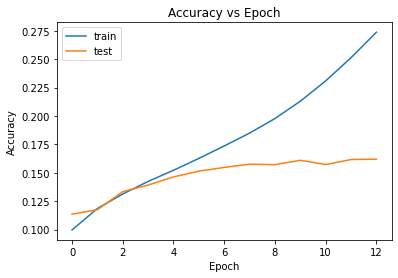

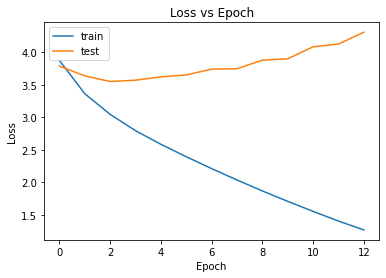

In [39]:
#Plot the accuracy and loss per epoch plot
#Accuracy vs epoch
pyplot.plot(history.history['accuracy'], label='train') 
pyplot.plot(history.history['val_accuracy'], label='test') 
pyplot.title('Accuracy vs Epoch')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend() 
pyplot.show()

#Loss vs epoch
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.title('Loss vs Epoch')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend() 
pyplot.show()

## Section 3 Testing

---

**Task 5 (20 marks)**

* Use the trained model to translate the text from the source into the target language (10 marks). 
* Use the test/evaluation set (see Section 1) and perform an automatic evaluation with the BLEU metric (10 marks). 
You can use the NLTK library to calculate BLEU.

In [40]:
#Load the saved seq2seq model weights
model = Model([encoder_input, decoder_input], decoder_output)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.load_weights('seq2seq_source_target.h5')

In [41]:
#Inference model for prediction or evaluation
#Encoder model
encoder_model = Model(encoder_input, encoder_state)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
embedded_decoder = Embedding(num_decoder_tokens, latent_dim)(decoder_input)
decoder_outputs, state_h, state_c = decoder_lstm(embedded_decoder, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

#Decoder model
decoder_model = Model(
  [decoder_input] + decoder_states_inputs,
  [decoder_outputs] + decoder_states)

In [42]:
#To be used while predicting the translation of a sentence
reverse_input_char_index = dict((i, word) for word, i in source_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [43]:
#Function to translate a given inout from one language to another
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)
  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1,1))
  # Populate the first character of target sequence with the start character.
  target_seq[0, 0] = target_token_index['<bof>']

  # Sampling loop for a batch of sequences
  # (to simplify, here we assume a batch of size 1).
  stop_condition = False
  decoded_sentence = ''
  while not stop_condition:
      output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

      # Sample a token
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += ' '+sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == '<eos>' or
          len(decoded_sentence) > 10):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,1))
      target_seq[0, 0] = sampled_token_index

      # Update states
      states_value = [h, c]

  return decoded_sentence.replace('<eos>','')

In [44]:
#Translating the test data from English to French language using trained model 
for seq_index in range(10):
  input_seq = encoder_input_test_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', X_test[seq_index])
  print('Decoded sentence:', decoded_sentence)

-
Input sentence: johannes rydberg swedish physicist and academic b
Decoded sentence:  peintre peintre
-
Input sentence: isbn jørn utzon bagsværd church logbook vol
Decoded sentence:  coffea peintre
-
Input sentence: leoš janáček czech composer and educator b
Decoded sentence:  peintre peintre
-
Input sentence: mario francesco pompedda italian cardinal b
Decoded sentence:  franz peintre
-
Input sentence: to get back to you phoebus
Decoded sentence:  le le le le
-
Input sentence: george archer american golfer b
Decoded sentence:  john acteur
-
Input sentence: world music vol
Decoded sentence:  air 
-
Input sentence: issn
Decoded sentence:  isbn 
-
Input sentence: pj
Decoded sentence:  
-
Input sentence: no
Decoded sentence:  


**BLEU Score**

In [45]:
original_sentence = []
translated_sentence = []

#Function to calculate the Bleu score to check model performance and the higher the score the better is the model performce as it measure similarity between two sentences
def bleu_score(encoder_data,y_data):
    for senetence_index in range(len(y_data)):
      input_seq = encoder_data[senetence_index: senetence_index + 1]
      decoded_sentence = decode_sequence(input_seq)
      if (len(decoded_sentence.split()) != 0) and (len(y_data[senetence_index].replace("<bof>","").replace("<eos>","").split()) != 0): #Check both original and translated sentences should not be empty
        original_sentence.append(y_data[senetence_index].replace("<bof>","").replace("<eos>","").split())
        translated_sentence.append(decoded_sentence.split())

    bleu_score_data = {}
    bleu_score_data['1-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(1.0, 0, 0, 0))
    bleu_score_data['2-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(0.5, 0.5, 0, 0))
    bleu_score_data['3-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(0.3, 0.3, 0.3, 0))
    bleu_score_data['4-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_score_data

#Evaluate the BLEU Score on test dataset
bleu_test_score = bleu_score(encoder_input_test_data, y_test)

In [46]:
print("Bleu score on Test data is:",bleu_test_score)

Bleu score on Test data is: {'1-grams': 0.0028551417524716417, '2-grams': 0.049145417750342826, '3-grams': 0.15339993424651627, '4-grams': 0.20389694044201165}


# Section 4 Attention

---



**Task 6 (40 Marks)** Sequence2Sequence

* Extend the existing Seq2Seq model with an attention mechanism [Discussed in Class]
* Create sequence2sequence model with attention (15 marks)
* Train the model with the same data from Section 1 (10 marks)
* Translate the evaluation set using the sequence2sequence attention model (10 marks)
* Evaluate the translations made with the sequence2sequence attention model and compare it with the model without attention using BLEU (5 marks)

In [64]:
#Encoder
encoder_input = Input(shape = (max_encoder_seq_length,), name = 'Encoder_input')
embedded_encoder = Embedding(num_words_inp, embedding_shape, weights=[embedding_matrix], trainable = False)(encoder_input)
encoder_output,state_h,state_c = LSTM(latent_dim, return_sequences=True,return_state=True)(embedded_encoder)
encoder_state = [state_h,state_c]

# Decoder
decoder_input    = Input(shape = (max_decoder_seq_length,), name = 'Decoder_input')
embedded_decoder = Embedding(num_decoder_tokens, latent_dim)(decoder_input)
decoder_lstm=LSTM(latent_dim, return_sequences=True,unroll=True)
decoder_output = decoder_lstm(embedded_decoder, initial_state = [encoder_output[:,-1,:],encoder_output[:,-1,:]])

# Attendtion layer
attention_dot_layer = dot([decoder_output, encoder_output], axes=[2,2])
attention_activate_layer = Activation('softmax', name='attention')(attention_dot_layer)
attention_context = dot([attention_activate_layer, encoder_output], axes=[2,1])
decoder_attention_concat = concatenate([attention_context, decoder_output])
output_context = TimeDistributed(Dense(2048, activation="tanh"))(decoder_attention_concat)
decoder_outputs = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"), name = 'Decoder_Dense')(output_context)

In [65]:
#Model compilation
attention_model = Model([encoder_input, decoder_input], decoder_outputs)
attention_model.compile(optimizer=RMSprop(learning_rate=0.002),loss='categorical_crossentropy', metrics=['accuracy'])
attention_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 9)]          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 9, 100)       1317300     Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, 11)]         0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 9, 256), (No 365568      embedding_9[0][0]                
___________________________________________________________________________________________

In [66]:
#Model Training
attention_history = attention_model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=epochs,
          validation_split=0.1,
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])
attention_model.save('seq2seq_source_target_attention.h5')

Epoch 1/100
117/117 [==============================] - 54s 399ms/step - loss: 4.5630 - accuracy: 0.0761 - val_loss: 3.5871 - val_accuracy: 0.1162
Epoch 2/100
117/117 [==============================] - 43s 369ms/step - loss: 3.0246 - accuracy: 0.1448 - val_loss: 3.1114 - val_accuracy: 0.1554
Epoch 3/100
117/117 [==============================] - 44s 375ms/step - loss: 2.5784 - accuracy: 0.1766 - val_loss: 3.1075 - val_accuracy: 0.1688
Epoch 4/100
117/117 [==============================] - 44s 375ms/step - loss: 2.2374 - accuracy: 0.2051 - val_loss: 3.0055 - val_accuracy: 0.1754
Epoch 5/100
117/117 [==============================] - 45s 382ms/step - loss: 1.9346 - accuracy: 0.2318 - val_loss: 2.9259 - val_accuracy: 0.1717
Epoch 6/100
117/117 [==============================] - 45s 386ms/step - loss: 1.6457 - accuracy: 0.2635 - val_loss: 2.9754 - val_accuracy: 0.1755
Epoch 7/100
117/117 [==============================] - 46s 393ms/step - loss: 1.4053 - accuracy: 0.2867 - val_loss: 3.0413 -

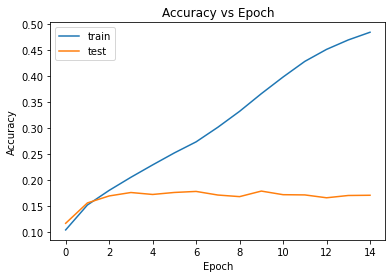

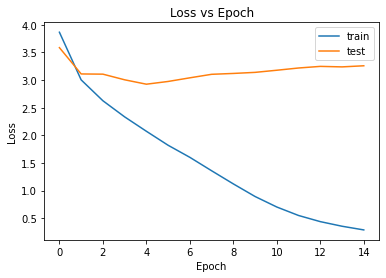

In [67]:
#Plot the accuracy and loss per epoch plot
#Accuracy vs epoch
pyplot.plot(attention_history.history['accuracy'], label='train') 
pyplot.plot(attention_history.history['val_accuracy'], label='test') 
pyplot.title('Accuracy vs Epoch')
pyplot.xlabel('Epoch')
pyplot.ylabel('Accuracy')
pyplot.legend() 
pyplot.show()

#Loss vs epoch
pyplot.plot(attention_history.history['loss'], label='train') 
pyplot.plot(attention_history.history['val_loss'], label='test') 
pyplot.title('Loss vs Epoch')
pyplot.xlabel('Epoch')
pyplot.ylabel('Loss')
pyplot.legend() 
pyplot.show()

In [68]:
#Inference attention model for prediction
#Encoder
encoder_model = Model(encoder_input, [encoder_output]+encoder_state)

#Decoder
decoder_states_inputs = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
decoder_inputs = Input(shape=(1,))
decoder_embedded = Embedding(num_decoder_tokens, latent_dim)(decoder_inputs)
decoder_lstm=LSTM(latent_dim, return_sequences=True,return_state=True, unroll=True)
decoded_seq, *decoder_states = decoder_lstm(decoder_embedded, initial_state=decoder_states_inputs)

#Decoder model
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoded_seq] + decoder_states)

# Attention
encoded_seq_in, decoded_seq_in = Input(shape=(max_encoder_seq_length, latent_dim)), Input(shape=(1, latent_dim))
score_dense = Dense(latent_dim)
score = score_dense(decoded_seq_in)
attention_dot = dot([score, encoded_seq_in], axes=[2,2])
attention_activate = Activation('softmax', name='attention')(attention_dot)
context = dot([attention_activate, encoded_seq_in], axes=[2,1])
concat = concatenate([context, decoded_seq_in])
output_cont = TimeDistributed(Dense(latent_dim, activation="tanh"))(concat)
attention_outputs = TimeDistributed(Dense(num_decoder_tokens, activation="softmax"), name = 'Decoder_Dense')(output_cont)

#Attention model
attention_model = Model([encoded_seq_in, decoded_seq_in], [attention_outputs, attention_activate])

In [69]:
def decode_sequence_attention(input_seq):
    # Encode the input as state vectors.
    encoded_seq, *states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['<bof>']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      # output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
      decoded_seq, h,c = decoder_model.predict([target_seq] + states_value)
      output_tokens, attention = attention_model.predict([encoded_seq, decoded_seq])
      # Sample a token
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_char = reverse_target_char_index[sampled_token_index]
      decoded_sentence += ' '+sampled_char

      # Exit condition: either hit max length
      # or find stop character.
      if (sampled_char == '<eos>' or
          len(decoded_sentence) > 10):
          stop_condition = True

      # Update the target sequence (of length 1).
      target_seq = np.zeros((1,1))
      target_seq[0, 0] = sampled_token_index

      # Update states
      states_value = [h, c]

    return decoded_sentence.replace('<eos>','')

In [70]:
for seq_index in range(10):
  input_seq = encoder_input_test_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence_attention(input_seq)
  print('-')
  print('Input sentence:', X_test[seq_index])
  print('Decoded sentence:', decoded_sentence)

-
Input sentence: she built her chapel
Decoded sentence:  souverain souverain
-
Input sentence: the sautoir is falling of its own weight
Decoded sentence:  was interprétation
-
Input sentence: lucio battisti italian singersongwriter and guitarist b
Decoded sentence:  vis vis murray
-
Input sentence: fayard paris
Decoded sentence:  wiley wiley
-
Input sentence: stahl
Decoded sentence:  pléiade pléiade
-
Input sentence: redirect orange sa
Decoded sentence:  vadim vadim
-
Input sentence: text online
Decoded sentence:  kessinger kessinger
-
Input sentence: ss in fw
Decoded sentence:  formale formale
-
Input sentence: its expenditure in was m€
Decoded sentence:  her her opération
-
Input sentence: he threatened bagnères and demanded a large sum
Decoded sentence:  illustration


**BLEU Score**

In [74]:
original_sentence = []
translated_sentence = []

#Function to calculate the Bleu score to check model performance and the higher the score the better is the model performce as it measure similarity between two sentences
def bleu_score_attention(encoder_data,y_data):
    for senetence_index in range(len(y_data)):
      input_seq = encoder_data[senetence_index: senetence_index + 1]
      decoded_sentence = decode_sequence_attention(input_seq)
      if (len(decoded_sentence.split()) != 0) and (len(y_data[senetence_index].replace("<bof>","").replace("<eos>","").split()) != 0): #Check both original and translated sentences should not be empty
        original_sentence.append(y_data[senetence_index].replace("<bof>","").replace("<eos>","").split())
        translated_sentence.append(decoded_sentence.split())

    bleu_score_data = {}
    bleu_score_data['1-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(1.0, 0, 0, 0))
    bleu_score_data['2-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(0.5, 0.5, 0, 0))
    bleu_score_data['3-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(0.3, 0.3, 0.3, 0))
    bleu_score_data['4-grams'] = corpus_bleu(original_sentence, translated_sentence, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_score_data

#Evaluate the BLEU Score on test dataset
bleu_test_attention_score = bleu_score_attention(encoder_input_test_data, y_test)

In [75]:
bleu_test_attention_score

{'1-grams': 0.002040480908207762,
 '2-grams': 0.038672362112551734,
 '3-grams': 0.12544921996419914,
 '4-grams': 0.16835839685175338}

**Result**
If we compare the Bleu score (4-grams) for seq2seq model with Bleu score (4-grams) of seq2seq with attention model then Seq2Se2 without attetnion performs better than seq2seq model with attention as the Bleu score(4-grams) in seq2seq without attention is 0.21 and in seq2seq with attention its 0.17.

Though adding attention to seq2seq model should have improved model performance as it gives more weights to important words. 

In [78]:
print("Bleu Score (4-grams) for seq2seq model is: {}".format(bleu_test_score['4-grams']))
print("Bleu Score (4-grams) for seq2seq with attention model is: {}".format(bleu_test_attention_score['4-grams']))

Bleu Score (4-grams) for seq2seq model is: 0.20389694044201165
Bleu Score (4-grams) for seq2seq with attention model is: 0.16835839685175338
